# Learning Rate Analysis for Centralized and Federated Experiments

This notebook analyzes the impact of learning rates on model performance for both centralized and federated training experiments within the `mlsys26` workspace. The primary goal is to visualize the relationship between the learning rate schedule and the training/validation loss.

## Overview

The notebook connects to Weights & Biases to perform the following steps:

1.  **Fetch and Group Runs**: It fetches all runs containing "fed" (federated) or "cen" (centralized) in their names. It then intelligently groups individual `wandb` runs into logical experiments. A federated experiment, comprising a server and multiple clients, is treated as a single entity.

2.  **Filter Experiments**: It filters the experiments to ensure data quality and relevance. The filtering criteria include:
    - **Termination Status**: Only experiments where all associated runs have terminated (e.g., 'finished' or 'crashed') are included.
    - **Training Completion**: Ensures that the runs have reached their target number of optimization steps.
    - **Configuration Matching**: Filters for specific model and optimizer configurations, such as batch size, FFN type, and initial learning rate.

3.  **Process Data**: For each logical experiment, it downloads the relevant metrics. To improve performance, it **caches the full history** of each run locally. For federated runs, it aggregates data from all client runs by averaging their metrics at each step.

4.  **Generate Plots**: The notebook produces a **dynamic grid of plots** where each subplot corresponds to a specific model configuration (batch size and FFN type). Within each plot, it visualizes:
    - **Loss vs. Steps**: The training or validation loss curve across optimization steps.
    - **Learning Rate vs. Steps**: The learning rate schedule on a secondary y-axis, providing context for changes in the loss curve.
    - Each line in a plot represents a run with a different initial learning rate, allowing for direct comparison of optimizer performance.

In [8]:
import logging
import math
import re
from collections import defaultdict
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import wandb
from matplotlib.ticker import FixedLocator, FuncFormatter
from tqdm.notebook import tqdm
from wandb.errors import Error as WandbError

from fedmoe_plots.wandb_utils import download_wandb_whole_history


def configure_logging_for_jupyter() -> None:
    """Configure the root logger for clear output in Jupyter notebooks."""
    root_logger = logging.getLogger()
    if root_logger.hasHandlers():
        root_logger.handlers.clear()
    handler = logging.StreamHandler()
    formatter = logging.Formatter(
        "%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    )
    handler.setFormatter(formatter)
    root_logger.addHandler(handler)
    root_logger.setLevel(logging.INFO)


configure_logging_for_jupyter()
log = logging.getLogger("lr_analysis.ipynb")

# --- W&B Configuration ---
WANDB_ENTITY = "camlsys"
WANDB_PROJECT = "mlsys26"
CACHE_DIR = ".cache/wandb_history"

DEFAULT_GROUPING_CONFIG_KEYS: dict[str, str] = {
    "batch_size": "llm_config.global_train_batch_size",
    "ffn_type": "llm_config.model.ffn_config.ffn_type",
    "local_steps": "fl.n_local_steps",
    "learning_rate": "llm_config.optimizer.lr",
}

## Utility Functions

In [9]:
def get_nested_value(d: dict[str, Any], key_string: str) -> Any | None:  # noqa: ANN401
    """Access a nested value using a dot-separated key.

    Parameters
    ----------
    d : dict[str, Any]
        The dictionary to access.
    key_string : str
        The dot-separated key string.
        The dot-separated key string.

    Returns
    -------
    Any | None
        The value if found, otherwise None.

    """
    keys = key_string.split(".")
    current_value = d
    for key in keys:
        try:
            if isinstance(current_value, dict):
                current_value = current_value[key]
            elif isinstance(current_value, list | tuple) and key.isdigit():
                current_value = current_value[int(key)]
            else:
                return None
        except (KeyError, IndexError, TypeError):
            return None
    return current_value


## Data Fetching and Processing

In [10]:
def fetch_and_group_experiments(entity: str, project: str) -> list[dict[str, Any]]:
    """Fetch runs from W&B and group them into logical experiments.

    Parameters
    ----------
    entity : str
        The W&B entity (user or team).
    project : str
        The W&B project name.

    Returns
    -------
    list[dict[str, Any]]
        A list of logical experiments, each represented as a dictionary with keys

    """
    log.info("🔄 Connecting to W&B and fetching runs from '%s/%s'.", entity, project)
    api = wandb.Api()
    try:
        runs = api.runs(
            path=f"{entity}/{project}",
            filters={"display_name": {"$regex": ".*(fed|cen).*"}},
        )
    except WandbError:
        log.exception("❌ Failed to fetch runs from W&B for %s/%s", entity, project)
        return []

    log.info("Found %d total runs. Grouping into logical experiments.", len(runs))

    grouped_runs = defaultdict(list)
    for run in tqdm(runs, desc="Grouping Runs"):
        base_name_match = re.match(r"^(.*?)(_server|_client_\d+)?$", run.name)
        if base_name_match:
            grouped_runs[base_name_match.group(1)].append(run)

    experiments = []
    for name, run_list in grouped_runs.items():
        exp_type = "federated" if "fed" in name else "centralized"
        experiments.append({"name": name, "type": exp_type, "runs": run_list})

    log.info("✅ Grouped into %d logical experiments.", len(experiments))
    return experiments

In [11]:
def filter_experiments(
    experiments: list[dict[str, Any]],
    config_filters: dict[str, Any],
    target_steps_key: str = "llm_config.scheduler.schedulers.lr.t_max",
    tolerance_steps: int = 1,
 ) -> list[dict[str, Any]]:
    """Filter a list of logical experiments based on status, completion, and config.

    Parameters
    ----------
    experiments : list[dict[str, Any]]
        The list of logical experiments to filter.
    config_filters : dict[str, Any]
        Configuration key-value pairs that each experiment must match.
    target_steps_key : str, optional
        The config key indicating the target number of training steps,
        by default "llm_config.scheduler.schedulers.lr.t_max".
    tolerance_steps : int, optional
        The number of steps below the target to still consider as complete,
        by default 1.

    Returns
    -------
    list[dict[str, Any]]
        The filtered list of experiments that meet all criteria.

    Raises
    ------
    ValueError
        If the target_steps_key is not found or
        cannot be converted to an integer in the config.

    """
    filtered_list: list[dict[str, Any]] = []
    log.info(
        "🔍 Filtering %d experiments with %d config filters (tolerance=%d steps).",
        len(experiments),
        len(config_filters),
        tolerance_steps,
    )

    for exp in tqdm(experiments, desc="Filtering Experiments"):
        exp_name = exp.get("name", "unknown")
        runs = exp.get("runs", [])
        if not runs:
            log.debug("Skipping %s: no runs present.", exp_name)
            continue

        is_terminated = all(r.state in {"finished", "crashed", "failed"} for r in runs)
        if not is_terminated:
            states = [r.state for r in runs]
            log.debug("Skipping %s: runs not terminated (states=%s).", exp_name, states)
            continue

        sample_run = runs[0]
        config_match = all(
            get_nested_value(sample_run.config, key) == val
            for key, val in config_filters.items()
        )
        if not config_match:
            log.debug("Skipping %s: config mismatch.", exp_name)
            continue

        try:
            target_steps_val = get_nested_value(sample_run.config, target_steps_key)
            target_steps = (int(target_steps_val.strip("ba"))
                                if isinstance(target_steps_val, str) else None
                            )
            if target_steps is None:
                raise ValueError  # noqa: TRY301
        except (ValueError, AttributeError):
            log.debug(
                "Skipping %s: invalid or missing target steps key '%s'.",
                exp_name,
                target_steps_key,
            )
            continue

        runs_to_check = ([r for r in runs if "_client_" in r.name]
                         if exp["type"] == "federated" else runs
                        )
        if not runs_to_check:
            log.debug("Skipping %s: no client runs to check for completion.", exp_name)
            continue

        def _meets_tolerance(step_value: int) -> bool:
            return step_value + tolerance_steps >= target_steps  # pyright: ignore[reportOperatorIssue]  # noqa: B023

        is_complete = all(_meets_tolerance(r.summary.get("_step", 0))
                          for r in runs_to_check)
        if not is_complete:
            max_step = max((r.summary.get("_step", 0) for r in runs_to_check),
                           default=0,
                           )
            log.debug(
                "Skipping %s: max step %s < target %s within tolerance %s.",
                exp_name,
                max_step,
                target_steps,
                tolerance_steps,
            )
            continue

        filtered_list.append(exp)

    log.info("✅ Found %d experiments matching all criteria.", len(filtered_list))
    return filtered_list

In [12]:
def process_experiments(  # noqa: C901
    experiments: list[dict[str, Any]],
    metrics: list[str],
) -> pd.DataFrame:
    """Download/cache metrics and aggregates federated client runs.

    Parameters
    ----------
    experiments : list[dict[str, Any]]
        The list of logical experiments to process.
    metrics : list[str]
        The list of metric names to extract from each experiment.

    Returns
    -------
    pd.DataFrame
        A DataFrame where each row corresponds to an experiment with its
        name, type, config, and processed metric data.

    """
    results = []
    log.info("📊 Processing %d experiments to get data.", len(experiments))
    columns_to_keep = ["_step", *metrics]

    def _select_relevant_columns(df: pd.DataFrame) -> pd.DataFrame:
        if not isinstance(df, pd.DataFrame) or df.empty:
            return pd.DataFrame()
        available_cols = [col for col in columns_to_keep if col in df.columns]
        missing_cols = [col for col in columns_to_keep if col not in df.columns]
        if missing_cols:
            log.debug("History missing columns %s", missing_cols)
        if "_step" not in available_cols or len(available_cols) <= 1:
            return pd.DataFrame()
        return df[available_cols].dropna()

    for exp in tqdm(experiments, desc="Processing Data"):
        try:
            if exp["type"] == "centralized":
                run = exp["runs"][0]
                history = download_wandb_whole_history(run)
                processed_df = _select_relevant_columns(history)
            else:  # Federated
                client_runs = [r for r in exp["runs"] if "_client_" in r.name]
                if not client_runs:
                    log.warning(
                        "⚠️ Skipping federated experiment %s : no client runs.",
                        exp["name"],
                    )
                    continue

                client_dfs = []
                for cr in client_runs:
                    history = download_wandb_whole_history(cr)
                    filtered_history = _select_relevant_columns(history)
                    if not filtered_history.empty:
                        client_dfs.append(filtered_history)
                client_dfs = [df for df in client_dfs if not df.empty]

                if not client_dfs:
                    log.warning("⚠️ Skipping %s: no valid client history found.", exp["name"])  # noqa: E501
                    continue

                full_df = pd.concat(client_dfs)
                processed_df = full_df.groupby("_step").mean().reset_index()

            if processed_df.empty:
                log.warning("⚠️ Skipping %s: processed data is empty.", exp["name"])
                continue

            results.append({
                "name": exp["name"],
                "type": exp["type"],
                "config": exp["runs"][0].config,
                "data": processed_df,
            })
        except Exception as _:
            log.exception("❌ Error processing %s", exp["name"])

    log.info("✅ Successfully processed %d experiments.", len(results))
    return pd.DataFrame(results)

## Visualization

In [ ]:
def generate_plots(  # noqa: C901, PLR0912, PLR0914, PLR0915
    results_df: pd.DataFrame,
    loss_metric_key: str,
    y_limits: tuple[float, float] | None = None,
    grouping_config_keys: dict[str, str] | None = None,
 ) -> None:
    """Aggregate final metrics per run and plots learning rate sweeps.

    Parameters
    ----------
    results_df : pd.DataFrame
        DataFrame with experiment results, each row containing 'name', 'type',
        'config', and 'data' (DataFrame of metrics).
    loss_metric_key : str
        The key of the loss metric to analyze (e.g., "eval/loss").
    y_limits : tuple[float, float] | None, optional
        Y-axis limits for the plots, by default None.
    grouping_config_keys : dict[str, str] | None, optional
        Mapping of config aliases to their dot-separated paths in the config.
        Must include "learning_rate"
        By default None, which uses DEFAULT_GROUPING_CONFIG_KEYS.

    Raises
    ------
    ValueError
        If 'learning_rate' is not included in grouping_config_keys.

    """
    if results_df.empty:
        log.warning("⚠️ Results DataFrame is empty. Cannot generate plots.")
        return

    if grouping_config_keys is None:
        grouping_config_keys = DEFAULT_GROUPING_CONFIG_KEYS.copy()
    if "learning_rate" not in grouping_config_keys:
        msg = "grouping_config_keys must include a 'learning_rate' entry."
        raise ValueError(msg)

    panel_group_columns: list[str] = ["experiment_type"]
    for alias in grouping_config_keys:
        if alias != "learning_rate" and alias not in panel_group_columns:
            panel_group_columns.append(alias)

    def _extract_final_metric(df: pd.DataFrame) -> float | None:
        if not isinstance(df, pd.DataFrame) or loss_metric_key not in df.columns:
            return None
        series = df[loss_metric_key].dropna()
        if series.empty:
            return None
        final_value = series.iloc[-1]
        if not np.isfinite(final_value):
            return None
        return float(final_value)

    def _normalize_config_value(alias: str, raw_value: Any) -> Any | None:  # noqa: ANN401, C901, PLR0911
        if raw_value is None:
            return None
        if alias == "learning_rate":
            try:
                return float(raw_value)
            except (TypeError, ValueError):
                return None
        if isinstance(raw_value, int | np.integer):
            return int(raw_value)
        if isinstance(raw_value, float | np.floating):
            return float(raw_value)
        if isinstance(raw_value, str):
            stripped = raw_value.strip()
            if alias in {"batch_size", "local_steps"} and stripped.isdigit():
                return int(stripped)
            try:
                numeric_val = float(stripped)
                if numeric_val.is_integer():
                    return int(numeric_val)
                return numeric_val  # noqa: TRY300
            except ValueError:
                return stripped
        if isinstance(raw_value, bool):
            return raw_value
        return str(raw_value)

    def _apply_scientific_offset(axis: Any, values: np.ndarray) -> None:  # noqa: ANN401
        finite_vals: list[float] = []
        for raw_val in values:
            if not isinstance(raw_val, int | float | np.floating):
                continue
            val = float(raw_val)
            if not math.isfinite(val) or val == 0.0:
                continue
            finite_vals.append(val)
        if not finite_vals:
            axis.offsetText.set_visible(False)
            axis.offsetText.set_text("")
            axis.set_major_formatter(FuncFormatter(lambda val, _pos: f"{val:.4g}"))
            return
        max_abs = max(abs(v) for v in finite_vals)
        if max_abs == 0.0:
            axis.offsetText.set_visible(False)
            axis.offsetText.set_text("")
            axis.set_major_formatter(FuncFormatter(lambda _val, _pos: "0"))
            return
        exponent = math.floor(math.log10(max_abs))
        if exponent == 0:
            axis.offsetText.set_visible(False)
            axis.offsetText.set_text("")
            axis.set_major_formatter(FuncFormatter(lambda val, _pos: f"{val:.4g}"))
            return
        scale = 10 ** exponent
        formatter = FuncFormatter(
            lambda val, _pos: "0" if val == 0 else f"{(val / scale):.4g}",
        )
        axis.set_major_formatter(formatter)
        axis.offsetText.set_visible(True)
        axis.offsetText.set_text(rf"$\\times 10^{{{exponent}}}$")

    summary_records: list[dict[str, Any]] = []
    for _, row in results_df.iterrows():
        final_metric = _extract_final_metric(row["data"])
        if final_metric is None:
            log.debug("Skipping %s: missing %s values", row["name"], loss_metric_key)
            continue

        config = row["config"]
        config_values: dict[str, Any] = {}
        missing_required = False
        missing_optional: list[str] = []
        for alias, path in grouping_config_keys.items():
            raw_value = get_nested_value(config, path)
            normalized_value = _normalize_config_value(alias, raw_value)
            if normalized_value is None:
                if alias == "learning_rate":
                    missing_required = True
                    break
                missing_optional.append(alias)
            config_values[alias] = normalized_value
        if missing_required:
            log.debug("Skipping %s: missing learning_rate config for aggregation",
                      row["name"],
                      )
            continue
        for alias in missing_optional:
            config_values[alias] = "unknown"

        summary_records.append({
            "experiment_type": row["type"],
            **config_values,
            "final_metric": final_metric,
        })

    summary_df = pd.DataFrame(summary_records)
    if summary_df.empty:
        log.warning("⚠️ No runs with valid %s data.", loss_metric_key)
        return

    group_columns = panel_group_columns.copy()
    if "learning_rate" not in group_columns:
        group_columns.append("learning_rate")

    aggregated = (
        summary_df
        .groupby(group_columns, dropna=False)
        .agg(
            mean_metric=("final_metric", "mean"),
            std_metric=("final_metric", "std"),
            n_runs=("final_metric", "size"),
        )
        .reset_index()
    )
    aggregated["std_metric"] = aggregated["std_metric"].fillna(0.0)

    grouped_panels = list(aggregated.groupby(panel_group_columns, dropna=False))
    if not grouped_panels:
        log.warning("⚠️ No grouped configurations to visualize.")
        return

    n_panels = len(grouped_panels)
    n_cols = min(3, max(1, n_panels))
    n_rows = math.ceil(n_panels / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4.5 * n_rows),
                             squeeze=False)
    axes_flat = axes.flatten()
    metric_label = loss_metric_key.rsplit("/", maxsplit=1)[-1]

    for idx, (panel_key, panel_df) in enumerate(grouped_panels):
        ax = axes_flat[idx]
        if len(panel_group_columns) == 1:
            key_values = {panel_group_columns[0]: panel_key}
        else:
            key_values = dict(zip(panel_group_columns, panel_key, strict=False))
        ordered_series = panel_df.sort_values("learning_rate")
        lr_values = np.sort(ordered_series["learning_rate"].astype(float).unique())
        exp_type_value = key_values.get("experiment_type",
                                        panel_df["experiment_type"].iloc[0],
                                    )
        run_count = int(panel_df["n_runs"].sum())
        label = f"{str(exp_type_value).title()} (n={run_count})"
        ax.errorbar(
            ordered_series["learning_rate"],
            ordered_series["mean_metric"],
            yerr=ordered_series["std_metric"],
            fmt="o-",
            color=plt.cm.tab10(idx % 10),  # pyright: ignore[reportAttributeAccessIssue]
            linewidth=2,
            markersize=6,
            capsize=4,
            label=label,
        )

        ax.set_xlabel("Learning Rate", fontsize=12)
        ax.set_ylabel(metric_label, fontsize=12)
        ax.set_xscale("log")
        if y_limits is not None:
            ax.set_ylim(*y_limits)
        ax.grid(True, which="major", linestyle="--", alpha=0.6)  # noqa: FBT003
        ax.legend(loc="upper right")
        title_parts: list[str] = []
        for column in panel_group_columns:
            value = key_values.get(column, "unknown")
            if column == "experiment_type":
                label_name = "Type"
            else:
                label_name = column.replace("_", " ").title()
            title_parts.append(f"{label_name}: {value}")
        title_text = "\n".join(title_parts) if title_parts else "Learning Rate Sweep"
        ax.set_title(title_text, fontsize=13)

        if lr_values.size:
            ax.xaxis.set_major_locator(FixedLocator(lr_values))  # pyright: ignore[reportArgumentType]
            tick_values = lr_values
        else:
            tick_values = ax.get_xticks()
        _apply_scientific_offset(ax.xaxis, tick_values)

    for idx in range(n_panels, len(axes_flat)):
        axes_flat[idx].set_visible(False)

    fig.tight_layout(pad=3.0)
    plt.show()

    sort_columns = [col for col in group_columns if col in aggregated.columns]
    summary_table = aggregated.sort_values(sort_columns)
    log.info(
        "Aggregated LR vs %s table:\n%s",
        metric_label,
        summary_table.to_string(index=False, float_format="%.4f"),
    )

## Main Execution

2025-10-14 16:52:29,812 - lr_analysis.ipynb - INFO - 🔄 Connecting to W&B and fetching runs from 'camlsys/mlsys26'.
2025-10-14 16:52:30,459 - lr_analysis.ipynb - INFO - Found 308 total runs. Grouping into logical experiments.


Grouping Runs:   0%|          | 0/308 [00:00<?, ?it/s]

2025-10-14 16:52:32,759 - lr_analysis.ipynb - INFO - ✅ Grouped into 96 logical experiments.
2025-10-14 16:52:32,781 - lr_analysis.ipynb - INFO - 🔍 Filtering 96 experiments with 0 config filters (tolerance=1 steps).


Filtering Experiments:   0%|          | 0/96 [00:00<?, ?it/s]

2025-10-14 16:52:32,794 - lr_analysis.ipynb - INFO - ✅ Found 30 experiments matching all criteria.
2025-10-14 16:52:32,798 - lr_analysis.ipynb - INFO - 📊 Processing 30 experiments to get data.


Processing Data:   0%|          | 0/30 [00:00<?, ?it/s]

2025-10-14 16:53:06,453 - lr_analysis.ipynb - INFO - ✅ Successfully processed 30 experiments.
2025-10-14 16:53:06,455 - lr_analysis.ipynb - INFO - 
--- Plot Generation ---


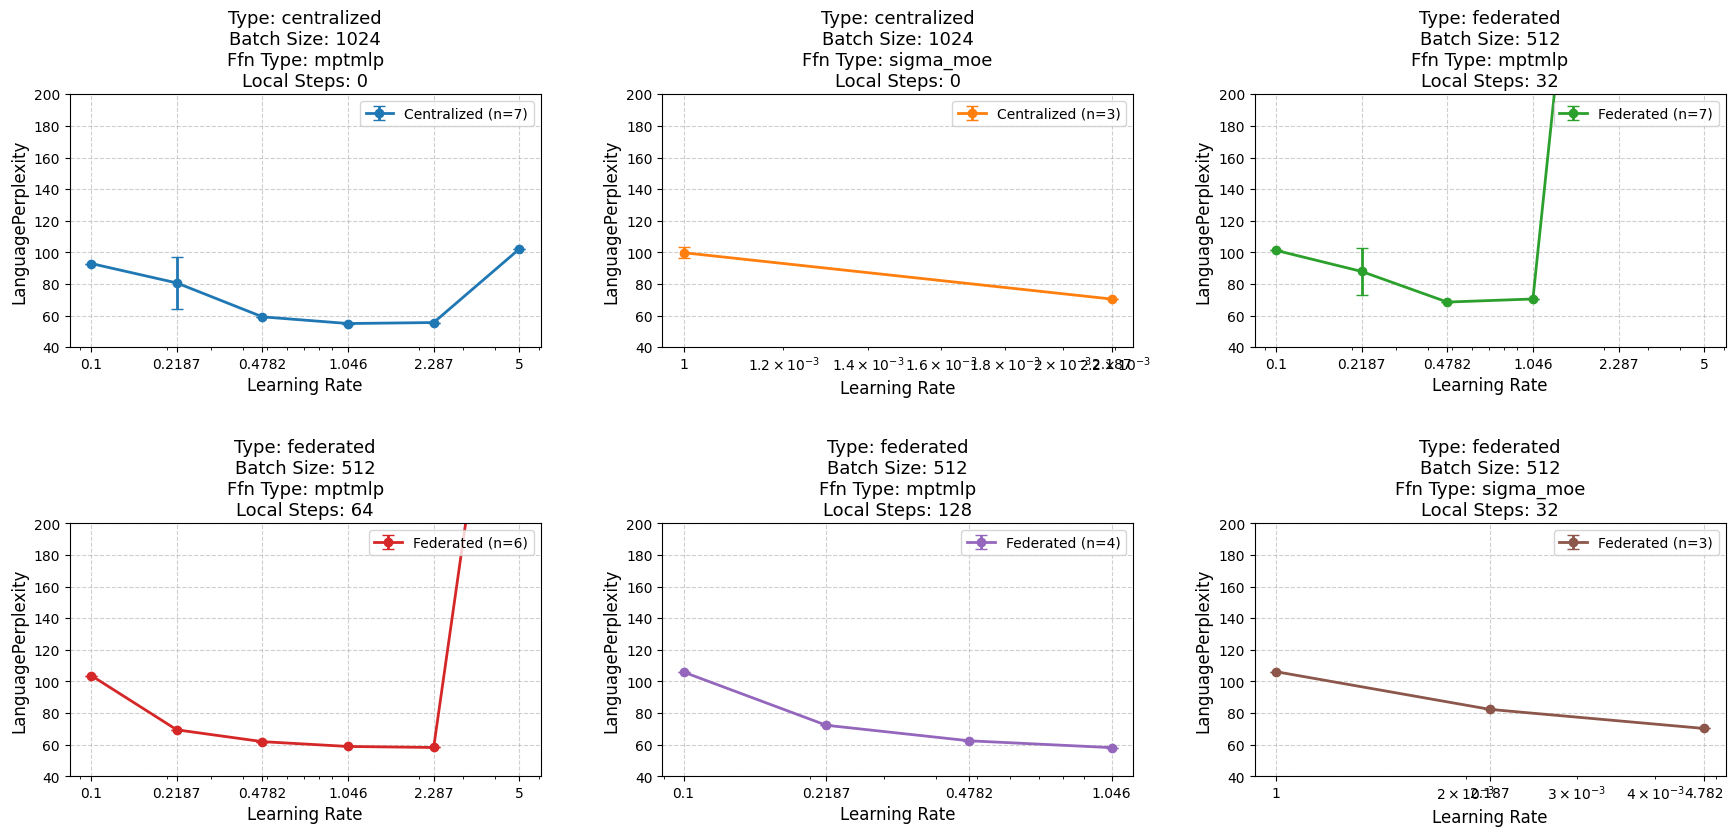

2025-10-14 16:53:07,166 - lr_analysis.ipynb - INFO - Aggregated LR vs LanguagePerplexity table:
experiment_type  batch_size  ffn_type  local_steps  learning_rate  mean_metric  std_metric  n_runs
    centralized        1024    mptmlp            0         0.0010      92.9940      0.0000       1
    centralized        1024    mptmlp            0         0.0022      80.7087     16.5151       2
    centralized        1024    mptmlp            0         0.0048      59.2687      0.0000       1
    centralized        1024    mptmlp            0         0.0105      55.0420      0.0000       1
    centralized        1024    mptmlp            0         0.0229      55.6618      0.0000       1
    centralized        1024    mptmlp            0         0.0500     102.1733      0.0000       1
    centralized        1024 sigma_moe            0         0.0010      99.8346      3.5610       2
    centralized        1024 sigma_moe            0         0.0022      70.5250      0.0000       1
      federat

In [14]:
# 1. Define filters for the experiments.
CONFIG_FILTERS = {
    # 'llm_config.global_train_batch_size': 512,
    # 'llm_config.model.ffn_config.ffn_type': 'mptmlp',
}

# 2. Choose the loss metric to plot.
LOSS_METRIC = "metrics/train/LanguagePerplexity"  # Or 'loss/validation'
METRICS_TO_DOWNLOAD = [LOSS_METRIC]
Y_LIMITS: tuple[float, float] | None = (40, 200)  # Example: (40, 200)
GROUPING_CONFIG_KEYS = DEFAULT_GROUPING_CONFIG_KEYS.copy()

# 3. Fetch and group all experiments from W&B.
all_experiments = fetch_and_group_experiments(WANDB_ENTITY, WANDB_PROJECT)

# 4. Filter experiments based on completion and configuration.
if all_experiments:
    filtered_experiments = filter_experiments(all_experiments,
                                              config_filters=CONFIG_FILTERS,
                                            )
else:
    filtered_experiments = []

# 5. Process filtered experiments to get data, using cache if available.
if filtered_experiments:
    results_df = process_experiments(filtered_experiments, metrics=METRICS_TO_DOWNLOAD)
else:
    results_df = pd.DataFrame()

# 6. Generate and display the plots.
if not results_df.empty:
    log.info("\n--- Plot Generation ---")
    generate_plots(
        results_df,
        loss_metric_key=LOSS_METRIC,
        y_limits=Y_LIMITS,
        grouping_config_keys=GROUPING_CONFIG_KEYS,
    )
else:
    log.warning("\nNo data available to generate plots after filtering.")